In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import numpy as np
import json
import os
import sys
import pickle
from scipy import ndimage

# for Jupyter lab
# %matplotlib widget
# for Jupyter notebook
# %matplotlib notebook
%matplotlib inline


In [8]:
Fun4all_path = os.path.abspath(os.path.join('..','..','..','..','CodesForAll'))
sys.path.append(Fun4all_path)

from plot_fun import colorize, adjust_lightness, get_blue_map
from analy_fun import cpx_corr, fidelity, seq_cpx_corr

In [9]:
from pyTen.decompositions import hosvd, als3herm, als4herm2

In [10]:
from fisher_functions import get_W3, get_W4

In [ ]:
from functions import getOutputFields, fisherPerMode, \
    fisher, getFisherOperator
from functions import resize_modes
from functions import cpx_zoom

In [19]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title



plt.rc('figure', facecolor='white') # white background for VSC
cmap_int = 'gist_heat'
cmap_fish = 'inferno'

function = fidelity
noise = 'gaussian'#'poisson'

data_path = os.path.abspath(os.path.join('..','..','MyData')) #pc
# data_path = os.path.abspath(os.path.join('..','..','..','My_data','GRIN')) #mac
fig_path = os.path.abspath(os.path.join('..','Figs'))


# 1. Load data

In [20]:
with open(os.path.join(data_path, 'param.pkl'), 'rb') as file:
        param = pickle.load(file, encoding='latin1')

In [21]:
modes = np.load(os.path.join(data_path,'modes.npz'))

N_in = param['fiber']['inpoints'] 
N_out = param['fiber']['onpoints'] 
steps_pressure = param['Deformation']['steps_pressure']
n_steps = len(steps_pressure)
n_mod = param['modes']['num_modes']

In [22]:
modes_out = modes['modes_out1_corr']
modes_in = modes['modes_in_corr']

TM_full_pix = np.load(os.path.join(data_path,'TMs_pix.npy'))
TM_full_mod = np.load(os.path.join(data_path,'TMs_mode.npy'))

TM_pix = TM_full_pix[:,:N_out**2]
TM_mod = TM_full_mod[:,:n_mod] # modes_out.conj() @ TM_pix[0]@ modes_in.T

TM_mix =  TM_pix @ modes_in.T

# 2. Sensitivity to deformation

## 2.1 Compute crashing modes and MIIS

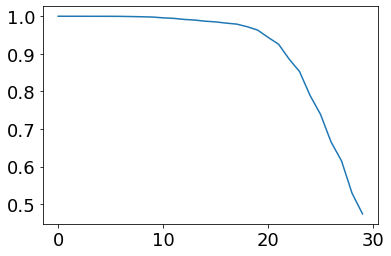

In [30]:
plt.plot(fidelity(TM_mod,TM_mod[0]))

In [ ]:
# central deformation to estimate the WS operator
center_TM_index = 23
# step to evaluate the derivative
step = 1

Hmix_list = [TM_mix[center_TM_index - step], 
                      TM_mix[center_TM_index], 
                      TM_mix[center_TM_index + step]]
W_ten = get_W3(Hmix_list)

In [ ]:
us_hosvd, s_hosvd = hosvd(W_ten)
f_sings = np.empty(55)
for i in range(55):
    f_sings[i] = fisher(us_hosvd[2][:,i], [Hmix_list[0],Hmix_list[-1]], noise=noise)
sorted_ind = np.argsort(f_sings)

# 3. Pixel Fisher and out fields

# 4. Estimating change in perturbation

# 5. Optimal output modes

# 6. Optimal output basis